In [1]:
# lets build cifar 10 classifier from scratch

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

/Users/hemant/Documents/Cifar_10_classifier/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
#lets load our dataset, only converting to tensor, we will be adding transformations later
train_data = datasets.CIFAR10('./data', train=True, download=True, transform= transforms.ToTensor())

#pin_memory parameter will be useful for GPUs
train_loader_args = {"batch_size": 64, "shuffle":True, "num_workers":2, "pin_memory":True}
train_loader = DataLoader(train_data, **train_loader_args)

Files already downloaded and verified


In [4]:
train_data.data[0].shape

(32, 32, 3)

In [5]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import lightning as L
import numpy as np

In [6]:
images, labels = next(iter(train_loader))
combined_image = make_grid(images, nrow=4)
combined_image.shape

/Users/hemant/Documents/Cifar_10_classifier/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hemant/Documents/Cifar_10_classifier/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


torch.Size([3, 546, 138])

/Users/hemant/Documents/Cifar_10_classifier/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hemant/Documents/Cifar_10_classifier/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


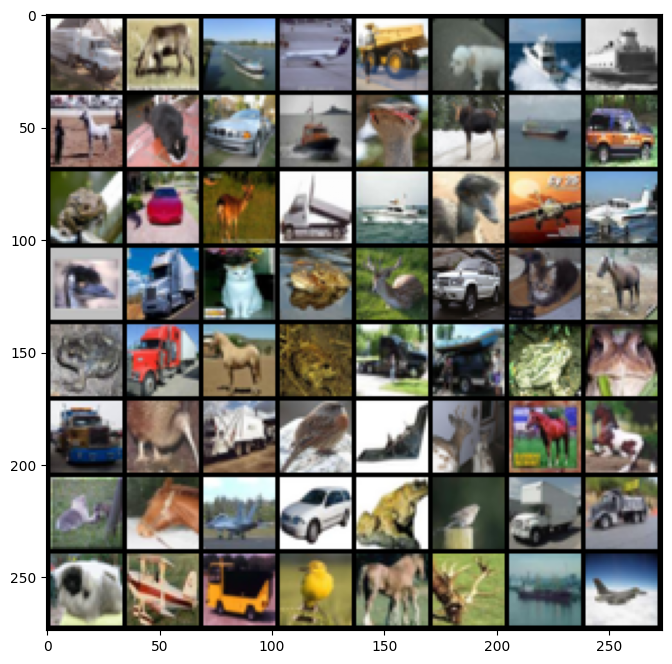

In [7]:
def visualise_dataset(train_loader):
    images, labels = next(iter(train_loader))
    
    combined_image = make_grid(images, nrow=8)
    plt.figure(figsize=(16,8))
    plt.imshow(combined_image.numpy().transpose(1,2,0))
visualise_dataset(train_loader)

In [8]:
import torch.nn as nn

In [9]:
def convblock(in_channels, out_channels, kernel, stride=1, padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, stride, padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Dropout(0.1)
    )

In [10]:
import torch.nn.functional as F
import torch.optim as optim

In [11]:
class nn_model(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 =  convblock(3,16,3,1,1) #32 output size
        self.conv2 = convblock(16,16,3,1,1) #32 output size
        self.pool1 = nn.MaxPool2d(2) #16

        self.conv3 = convblock(16,32,3,1,1) #16
        self.conv4 = convblock(32,32, 3, 1, 1) #16
        self.pool2  = nn.MaxPool2d(2) #8

        self.conv5 = convblock(32, 64, 3) #6
        self.conv6 = convblock(64, 64,3) #4
        self.conv7 = nn.AdaptiveAvgPool2d(1) # reduces our output to size 1 
        # we need one fully connected layer here
        self.fc1  = nn.Linear(64,10)
    def forward(self,x):
        x= self.pool1(self.conv2(self.conv1(x)))
        x= self.pool2(self.conv4(self.conv3(x)))
        x= self.conv7(self.conv6(self.conv5(x)))
        x = x.view(-1, 64) #because we have total 10 classes
        x= self.fc1(x)
        return x
    def training_step(self, batch, batch_idx):
        images, labels = batch
        output= self.forward(images)
        prediction = output.argmax(axis=1)
        loss= F.cross_entropy(output, labels)
        self.log("loss", loss)
        accuracy = prediction.eq(labels).sum().item()
        self.log("accuracy", accuracy)
        return loss
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.001)
        return optimizer

In [12]:
model = nn_model()

In [13]:
from torchsummary import summary
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,320
              ReLU-6           [-1, 16, 32, 32]               0
       BatchNorm2d-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
         MaxPool2d-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           4,640
             ReLU-11           [-1, 32, 16, 16]               0
      BatchNorm2d-12           [-1, 32, 16, 16]              64
          Dropout-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1, 32,

In [14]:
trainer = L.Trainer(precision="16-true") # it reduces the training time

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/hemant/Documents/Cifar_10_classifier/venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [15]:
trainer.fit(model, train_loader)

/Users/hemant/Documents/Cifar_10_classifier/venv/lib/python3.9/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name  | Type              | Params
--------------------------------------------
0 | conv1 | Sequential        | 480   
1 | conv2 | Sequential        | 2.4 K 
2 | pool1 | MaxPool2d         | 0     
3 | conv3 | Sequential        | 4.7 K 
4 | conv4 | Sequential        | 9.3 K 
5 | pool2 | MaxPool2d         | 0     
6 | conv5 | Sequential        | 18.6 K
7 | conv6 | Sequential        | 37.1 K
8 | conv7 | AdaptiveAvgPool2d | 0     
9 | fc1   | Linear            | 650   
--------------------------------------------
73.2 K    Trainable params
0         Non-trainable params
73.2 K    Total params
0.293     Total estimated model params size (MB)
/Users/hemant/Documents/Cifar_10_classifier/venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connec

Epoch 0:   0%|          | 0/782 [00:00<?, ?it/s] 

: 

In [ ]:
#lets do it google colab